<a href="https://colab.research.google.com/github/villasen/colab_notebooks/blob/master/Full_Integer_Quantization_of_Weights_and_Activations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load Dataset

In [1]:
!git clone https://github.com/villasen/small-urban-sound-dataset.git
!rm -r sample_data

Cloning into 'small-urban-sound-dataset'...
remote: Enumerating objects: 9724, done.
remote: Counting objects: 100% (9724/9724), done.
remote: Compressing objects: 100% (9328/9328), done.
remote: Total 9724 (delta 400), reused 9716 (delta 394), pack-reused 0
Receiving objects: 100% (9724/9724), 259.08 MiB | 13.89 MiB/s, done.
Resolving deltas: 100% (400/400), done.
Checking out files: 100% (18530/18530), done.


### Load Libraries, utilites and Function definitions

In [73]:
import keras
from keras import layers
from keras import models
from keras import backend as K
from keras import optimizers
from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import numpy as np
import librosa
import tensorflow
import scipy
import os, shutil
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from six.moves import urllib
import sys
import tarfile
import os.path
from os import path
from tensorflow.python.ops import io_ops
from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio


from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from numpy  import array
from tensorflow.contrib.quantize.python import fold_batch_norms
from tensorflow.contrib.quantize.python import quantize
from tensorflow.python.framework import ops
print(tf.__version__)






########### FUNCTIONS

def urban_wav2mfcc(file_path, max_pad_len):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    #mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=10, n_fft=3200, hop_length=1600)
    mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=10, n_fft=640, hop_length=320)
    
    pad_width = max_pad_len - mfcc.shape[1]
    #print(max_pad_len)
    #print(mfcc.shape[1])
    #print(pad_width)
    if pad_width < 0: 
      print(mfcc.shape[1])
      print(pad_width)
      print("error in "+ file_path)
    
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc 


  
  
def load_wav_file(wav_file):
  with tf.Session(graph=tf.Graph()) as sess:
      wav_filename_placeholder = tf.placeholder(tf.string, [])
      wav_loader = io_ops.read_file(wav_filename_placeholder)
      wav_decoder = contrib_audio.decode_wav(wav_loader, desired_channels=1)
      return sess.run(
          wav_decoder,
          feed_dict={wav_filename_placeholder: wav_file}).audio.flatten()





def quantize_wav(wav_tensor):
    with tf.Session(graph=tf.Graph()) as sess:
        my_quant = tf.quantization.quantize(
            # input
            wav_tensor,
            #min_range    -32768
            -1.0,
            # max_range    32677
            1.0,
            # T
            tf.qint16,
            # modes . 'MIN_COMBINED', "MIN_FIRST", "SCALED"
            #mode='SCALED',
            mode="MIN_COMBINED",
            #mode="MIN_FIRST",
            # round_mode='HALF_AWAY_FROM_ZERO', 'HALF_TO_EVEN'
            round_mode='HALF_AWAY_FROM_ZERO',
            #round_mode='HALF_TO_EVEN',
            name=None)
        return sess.run(my_quant).output
  
  
  
def build_speech_model():
  return keras.Sequential([
      
    keras.layers.Conv2D(64, (4,10), strides=(2,2), padding='same', activation='relu', input_shape=(10,51,1)),     
    #keras.layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0),
# Depthwise layers
    keras.layers.SeparableConv2D(64, (3,3), strides=(1,1), data_format='channels_last', padding='same', depth_multiplier=1, activation='relu'),
    keras.layers.Conv2D(64, (1,1), strides=(1,1), padding='same', use_bias=False, activation='relu'),
    keras.layers.Dropout(0.5),

#    keras.layers.SeparableConv2D(64, (3,3), strides=(1,1), data_format='channels_last', padding='same', depth_multiplier=1, activation='relu'),
#    keras.layers.Conv2D(64, (1,1), strides=(1,1), padding='same', use_bias=False, activation='relu'),
#    keras.layers.Dropout(0.5),

#    keras.layers.SeparableConv2D(64, (3,3), strides=(1,1), data_format='channels_last', padding='same', depth_multiplier=1, activation='relu'),
    
#    keras.layers.Conv2D(64, (1,1), strides=(1,1), padding='same', use_bias=False, activation='relu'),
#    keras.layers.Dropout(0.5),  
#    keras.layers.SeparableConv2D(64, (3,3), strides=(1,1), data_format='channels_last', padding='same', depth_multiplier=1, activation='relu'),
    
#     keras.layers.Conv2D(64, (1,1), strides=(1,1), padding='same', use_bias=False, activation='relu'),
      
      
    keras.layers.AveragePooling2D(pool_size=(5, 25), strides=(2,2), padding='valid', data_format=None),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(data_format=None),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
      
    keras.layers.Dense(3, activation='softmax')     
      
      
  ])  


######################

# Installing tf version 1.15
! pip uninstall -y tensorflow
! pip install -U tf-nightly

!rm -rf /tmp/urban_sound_models
# !pip install -q tensorflow==2.0.0-rc1
# from __future__ import absolute_import, division, print_function, unicode_literals
# import tensorflow as tf
# print(tf.__version__)

1.15.0-dev20190821
Requirement already up-to-date: tf-nightly in /usr/local/lib/python3.6/dist-packages (1.15.0.dev20190821)


In [16]:
#############  Preparing input data


DATA_PATH= '/content/small-urban-sound-dataset/tiny-dataset/'
!ls -al small-urban-sound-dataset/tiny-dataset/


labels = os.listdir('small-urban-sound-dataset/tiny-dataset/')
print(labels)


test_single_file = '/content/test_single_file/'
if path.exists('/content/test_single_file/') :
    print ("folder test_single exits, removing")
    !rm -rf /content/test_single_file
os.mkdir(test_single_file)


target_npy_files = "/content/target_npy_files/"
if path.exists("/content/target_npy_files/") :
    print ("folder target_npy_files exits, removing")
    !rm -rf /content/target_npy_files
os.mkdir(target_npy_files)


target_txt_files = "/content/target_txt_files/"
if path.exists("/content/target_txt_files/") :
    print ("folder target_txt_files folder exits, removing")
    !rm -rf /content/target_txt_files
os.mkdir(target_txt_files)


if path.exists("/content/test_single_file/frog") :
    print ("folder test_single_file/frog exits, removing")
    !rm -rf /content/test_single_file/frog
os.mkdir('/content/test_single_file/frog')

if path.exists("/content/test_single_file/crow") :
    print ("folder test_single_file/crow exits, removing")
    !rm -rf /content/test_single_file/crow
os.mkdir('/content/test_single_file/crow')

if path.exists("/content/test_single_file/crickets") :
    print ("folder test_single_file/crickets exits, removing")
    !rm -rf /content/test_single_file/crickets
os.mkdir('/content/test_single_file/crickets')




!cp -r /content/small-urban-sound-dataset/tiny-dataset/frog/1-18755-B.wav  /content/test_single_file/frog/
!cp -r /content/small-urban-sound-dataset/tiny-dataset/crow/2-108767-C.wav  /content/test_single_file/crow/
!cp -r /content/small-urban-sound-dataset/tiny-dataset/crickets/1-57318-A.wav  /content/test_single_file/crickets/



path = DATA_PATH
labels = os.listdir(path) 
print(labels)
print(type(labels))
max_feature = 0
for label in labels:
  mfcc_vectors=[]
   
  wavefiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
    
  if label=='crow' or label=='frog' or label=='crickets': 
    for wavfile in wavefiles:
            
      max_pad_len = 51
      #mfcc = urban_wav2mfcc(wavfile, 51)
      wave, sr = librosa.load(wavfile , mono=True, sr=None)
      #mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=10, n_fft=3200, hop_length=1600)
      mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=10, n_fft=640, hop_length=320)

      pad_width = max_pad_len - mfcc.shape[1]
      #print(max_pad_len)
      #print(mfcc.shape[1])
      #print(pad_width)
      if pad_width < 0: 
        print(mfcc.shape[1])
        print(pad_width)
        print("error in "+ file_path)
      mfcc_vectors.append(mfcc)


    np.save('/content/target_npy_files/' + label + '.npy', mfcc_vectors)
    np.savetxt('/content/target_txt_files/' + label + '.txt', mfcc_vectors[2], delimiter=', ')
    print(label)
    
    
split_ratio = 0.8
random_state = 42

npy_files= os.listdir('/content/target_npy_files/')
print(npy_files)

X = np.load('/content/target_npy_files/' + npy_files[0])
y = np.zeros(X.shape[0])
print(npy_files[0])
print(X.shape)



# # Append all of the dataset into one single array, same goes for 
for i, label in enumerate(npy_files[1:]):
   x = np.load('/content/target_npy_files/' + label)
  
#     #x = np.load('/content/speech-numpy/' + label)

   X = np.vstack((X, x))
   y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))


# return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)


X_train = X_train.reshape(X_train.shape[0], 10, 51, 1)
X_test = X_test.reshape(X_test.shape[0], 10, 51, 1)
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)


mfcc_crow = urban_wav2mfcc('test_single_file/crow/2-108767-C.wav', max_pad_len=51)
mfcc_crickets = urban_wav2mfcc('test_single_file/crickets/1-57318-A.wav', max_pad_len=51)
mfcc_frog = urban_wav2mfcc('test_single_file/frog/1-18755-B.wav', max_pad_len=51)


crow_file = mfcc_crow.reshape(1, 10, 51, 1)
crickets_file = mfcc_crickets.reshape(1, 10, 51, 1)
frog_file = mfcc_frog.reshape(1, 10, 51, 1)


np.save('/content/' + 'crow_single.npy', crow_file)
np.save('/content/' + 'frog_single.npy', frog_file)
np.save('/content/' + 'crickets_single.npy', crickets_file)


total 56
drwxr-xr-x 14 root root 4096 Oct  1 03:08 .
drwxr-xr-x  6 root root 4096 Oct  1 03:08 ..
drwxr-xr-x  2 root root 4096 Oct  1 03:08 crackling_fire
drwxr-xr-x  2 root root 4096 Oct  1 03:08 crickets
drwxr-xr-x  2 root root 4096 Oct  1 03:08 crow
drwxr-xr-x  2 root root 4096 Oct  1 03:08 crying_baby
drwxr-xr-x  2 root root 4096 Oct  1 03:08 door_knock
drwxr-xr-x  2 root root 4096 Oct  1 03:08 door_wood_creacks
drwxr-xr-x  2 root root 4096 Oct  1 03:08 drinking_sipping
drwxr-xr-x  2 root root 4096 Oct  1 03:08 fireworks
drwxr-xr-x  2 root root 4096 Oct  1 03:08 footsteps
drwxr-xr-x  2 root root 4096 Oct  1 03:08 frog
drwxr-xr-x  2 root root 4096 Oct  1 03:08 glass_breaking
drwxr-xr-x  2 root root 4096 Oct  1 03:08 handsaw
['handsaw', 'door_wood_creacks', 'glass_breaking', 'door_knock', 'crying_baby', 'fireworks', 'drinking_sipping', 'crackling_fire', 'frog', 'footsteps', 'crow', 'crickets']
folder test_single exits, removing
folder target_npy_files exits, removing
folder target_tx

Train on 96 samples, validate on 24 samples
Epoch 1/200
96/96 [==============================] - 1s 6ms/step - loss: 0.1239 - acc: 0.3125 - val_loss: 0.1016 - val_acc: 0.4167
Epoch 2/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0952 - acc: 0.4688 - val_loss: 0.0959 - val_acc: 0.4167
Epoch 3/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0972 - acc: 0.4063 - val_loss: 0.0929 - val_acc: 0.5000
Epoch 4/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0804 - acc: 0.5521 - val_loss: 0.0910 - val_acc: 0.5000
Epoch 5/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0827 - acc: 0.5625 - val_loss: 0.0878 - val_acc: 0.5000
Epoch 6/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0834 - acc: 0.5313 - val_loss: 0.0830 - val_acc: 0.6250
Epoch 7/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0751 - acc: 0.6354 - val_loss: 0.0832 - val_acc: 0.5417
Epoch 8/200
96/96 [====================

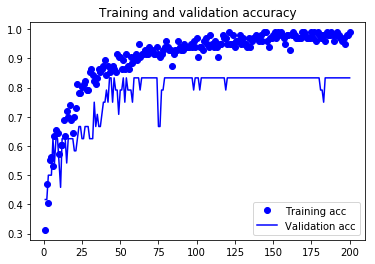

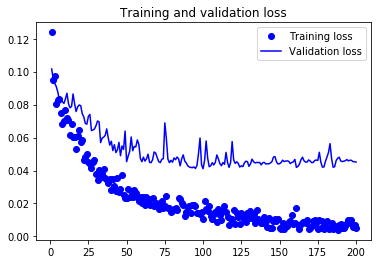

['frog.npy', 'crow.npy', 'crickets.npy']
[[9.9198687e-01 7.4935886e-03 5.1948044e-04]]
[[1.6548749e-04 9.9911684e-01 7.1773346e-04]]
[[3.97958161e-07 1.14893755e-05 9.99988079e-01]]


In [77]:
######### Here is where we start to build the model

!rm checkpoint
!rm checkpoints.data-00000-of-00001
!rm checkpoints.index
!rm checkpoints.meta


speech_graph = tf.Graph()
speech_sess = tf.Session(graph=speech_graph)

keras.backend.set_session(speech_sess)
with speech_graph.as_default():
     
  model = build_speech_model()
  
  # Quantization Aware Training #####
  ##tf.contrib.quantize.create_training_graph(sess.graph)  <--- this is old
  
  #tf.contrib.quantize.create_training_graph(input_graph=speech_graph, quant_delay=20)
  
  ##sess.run(tf.global_variables_initializer()) 
  
  
  
  
#  tf.contrib.quantize.create_training_graph(input_graph=speech_graph, quant_delay=2000000)
#  speech_sess.run(tf.global_variables_initializer())
  ####################
  
# LOSS FUNCTIONS:
# categorical_crossentropy
# logcosh
# cosine_proximity
# poisson

# OPTIMIZERS:
# adam
# adamax
# SGD
# RMSprop
# Adagrad
# Adadelta
  
  model.compile(optimizer='adamax', loss='logcosh', metrics=['accuracy'])
  
  history = model.fit(X_train, y_train_hot, batch_size=10, epochs=200, verbose=1, validation_data=(X_test, y_test_hot))
  #history = model.fit(X_train, y_train_hot, epochs=3)
  saver = tf.train.Saver()
  saver.save(speech_sess, 'checkpoints')
  
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs,val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()
  
  
  final_prediction1 = model.predict(frog_file)
  final_prediction2 =  model.predict(crow_file)
  final_prediction3 =  model.predict(crickets_file)
  
  
  
  print(npy_files)
  print(final_prediction1)
  print(final_prediction2)
  print(final_prediction3)
#########  End of training

In [78]:
eval_speech_graph = tf.Graph()
eval_speech_sess = tf.Session(graph=eval_speech_graph)

keras.backend.set_session(eval_speech_sess)
with eval_speech_graph.as_default():
    keras.backend.set_learning_phase(0)
    eval_model = build_speech_model()

    #For quantization aware training only
    #tf.contrib.quantize.create_eval_graph(input_graph=eval_speech_graph)
    eval_speech_graph_def = eval_speech_graph.as_graph_def()
    saver = tf.train.Saver()
    saver.restore(eval_speech_sess, 'checkpoints')

    frozen_graph_def = tf.graph_util.convert_variables_to_constants( eval_speech_sess, eval_speech_graph_def, 
                                                                    [eval_model.output.op.name] )

    with open('frozen_urban_model.pb', 'wb') as f:
      f.write(frozen_graph_def.SerializeToString())

    



INFO:tensorflow:Restoring parameters from checkpoints
INFO:tensorflow:Froze 10 variables.
INFO:tensorflow:Converted 10 variables to const ops.


In [0]:
import pathlib

In [0]:
tf.enable_eager_execution()
tf.logging.set_verbosity(tf.logging.DEBUG)

converter = tf.lite.TFLiteConverter.from_frozen_graph( "frozen_urban_model.pb", ["conv2d_1_input"], ["dense_2/Softmax"])
tflite_model = converter.convert()


In [0]:
tflite_models_dir = pathlib.Path("/tmp/urban_sound_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [82]:
# Obtaining a tflite model 

tflite_model_file = tflite_models_dir/"urban_model.tflite"
tflite_model_file.write_bytes(tflite_model)

66240

In [83]:
!ls -lh {tflite_models_dir}

total 68K
-rw-r--r-- 1 root root 65K Oct  1 05:54 urban_model.tflite


In [0]:
# Optimize for size
tf.logging.set_verbosity(tf.logging.INFO)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [0]:
# Create quantized values with an accurate dynamic range of activations, 
# for that need to provide a representative dataset

sounds = tf.cast(X_train, tf.float32)/255.0
urban_ds = tf.data.Dataset.from_tensor_slices((sounds)).batch(1)
def representative_data_gen():
  for input_value in urban_ds.take(100):
    yield [input_value]
    
converter.representative_dataset = representative_data_gen

In [86]:

tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"urban_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

25792

In [87]:
!ls -lh {tflite_models_dir}

total 96K
-rw-r--r-- 1 root root 26K Oct  1 05:54 urban_model_quant.tflite
-rw-r--r-- 1 root root 65K Oct  1 05:54 urban_model.tflite


In [88]:
# The converted model needs to be fully quantized. That means all ops need to be 
# quantized, no floats left. The input and outputs need to be integers too.

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()
tflite_model_quant_file = tflite_models_dir/"urban_model_quant_io.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

25864

In [89]:
!ls -lh {tflite_models_dir}

total 124K
-rw-r--r-- 1 root root 26K Oct  1 05:54 urban_model_quant_io.tflite
-rw-r--r-- 1 root root 26K Oct  1 05:54 urban_model_quant.tflite
-rw-r--r-- 1 root root 65K Oct  1 05:54 urban_model.tflite


### Loading test data

In [0]:
# Load data for float model
sounds = tf.cast(X_test, tf.float32)/255.0
urban_ds = tf.data.Dataset.from_tensor_slices(sounds).batch(1)

# Load data for quantized model
sounds_uint8 = tf.cast(X_test, tf.uint8)
urban_ds_uint8 = tf.data.Dataset.from_tensor_slices(sounds_uint8).batch(1)

In [0]:
crow_uint8 = tf.cast(crow_file, tf.uint8)
frog_uint8 = tf.cast(frog_file, tf.uint8)
crickets_uint8 = tf.cast(crickets_file, tf.uint8)
print(crow_uint8.shape)
print(crickets_uint8)

In [0]:
np.save('/content/' + 'crow_single_uint8.npy', crow_uint8)
np.save('/content/' + 'frog_single_uint8.npy', frog_uint8)
np.save('/content/' + 'crickets_single_uint8.npy', crickets_uint8)

In [90]:
print(sounds_uint8.shape)
print(sounds_uint8)

(24, 10, 51, 1)
tf.Tensor(
[[[[248]
   [ 36]
   [ 42]
   ...
   [222]
   [202]
   [181]]

  [[ 14]
   [247]
   [238]
   ...
   [  3]
   [  7]
   [ 16]]

  [[218]
   [216]
   [228]
   ...
   [250]
   [252]
   [ 12]]

  ...

  [[247]
   [235]
   [241]
   ...
   [239]
   [239]
   [237]]

  [[240]
   [243]
   [  4]
   ...
   [244]
   [239]
   [238]]

  [[  3]
   [ 10]
   [ 29]
   ...
   [ 16]
   [ 25]
   [  5]]]


 [[[217]
   [249]
   [  0]
   ...
   [148]
   [145]
   [131]]

  [[ 50]
   [  1]
   [235]
   ...
   [ 21]
   [ 30]
   [ 31]]

  [[214]
   [164]
   [163]
   ...
   [188]
   [191]
   [202]]

  ...

  [[  3]
   [254]
   [251]
   ...
   [  5]
   [ 11]
   [ 21]]

  [[241]
   [243]
   [243]
   ...
   [245]
   [254]
   [245]]

  [[  2]
   [ 14]
   [ 28]
   ...
   [  9]
   [ 15]
   [  3]]]


 [[[191]
   [155]
   [128]
   ...
   [142]
   [134]
   [ 55]]

  [[ 77]
   [154]
   [146]
   ...
   [ 92]
   [ 95]
   [ 48]]

  [[199]
   [128]
   [113]
   ...
   [118]
   [114]
   [184]]

  ...

  [

### use model in tflite interpreter

In [0]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [0]:
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

In [45]:
for sound in urban_ds:
  break

interpreter.set_tensor(interpreter.get_input_details()[0]["index"], sound)
interpreter.invoke()
predictions = interpreter.get_tensor(
    interpreter.get_output_details()[0]["index"])

print(predictions)

[[0.28681096 0.450979   0.26221004]]


In [46]:
for sound in urban_ds_uint8:
  break

interpreter_quant.set_tensor(
    interpreter_quant.get_input_details()[0]["index"], sound)
interpreter_quant.invoke()
predictions = interpreter_quant.get_tensor(
    interpreter_quant.get_output_details()[0]["index"])

print(predictions)

[[ 67 123  66]]


### How is my model doing

In [0]:
def eval_model(interpreter, urban_ds):
  total_seen = 0
  num_correct = 0

  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  for sound in mnist_ds:
    total_seen += 1
    interpreter.set_tensor(input_index, sound)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_index)
    if predictions == label.numpy():
      num_correct += 1

    if total_seen % 500 == 0:
      print("Accuracy after %i images: %f" %
            (total_seen, float(num_correct) / float(total_seen)))

  return float(num_correct) / float(total_seen)

urban_ds_demo = urban_ds.take(10)
print(eval_model(interpreter, urban_ds_demo))

### Running the TFLite model

In [0]:
#sounds_test = tf.cast(X_test, tf.float32)/255.0
#sounds_test = tf.dtypes.cast(X_test, tf.int8)/255.0
sounds_test = tf.dtypes.cast(X_test, tf.int8) 
urban_test_ds = tf.data.Dataset.from_tensor_slices(sounds_test).batch(1)

In [0]:
print(sounds_test.shape)
print(sounds_test)

In [0]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [0]:
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

In [0]:
for sound in urban_test_ds:
  break
  
interpreter.set_tensor(interpreter.get_input_details()[0]["index"], sound)
interpreter.invoke()
predictions = interpreter.get_tensor (interpreter.get_output_details()[0]["index"])

In [0]:
print(tf.__version__)


In [0]:
!pip install --upgrade tensorflow
